#  Прогнозирование заказов такси

**Импорт библиотек**

In [37]:
import warnings
warnings.filterwarnings("ignore") 
import pandas as pd 
import numpy as np
import math 

from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import mean_squared_error 
import time 

from sklearn.model_selection import GridSearchCV 
from sklearn.preprocessing import StandardScaler  
from sklearn.model_selection import cross_val_score 

from sklearn.linear_model import LinearRegression  
from sklearn.tree import DecisionTreeRegressor 
from sklearn.ensemble import RandomForestRegressor  

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor 
from sklearn.dummy import DummyRegressor 

from statsmodels.tsa.seasonal import seasonal_decompose  
from sklearn.model_selection import TimeSeriesSplit 

**Загрузим данные**

In [38]:
data_taxi = pd.read_csv("/datasets/taxi.csv", index_col=[0], parse_dates=[0])
#data_taxi = pd.read_csv("taxi.csv", index_col=[0], parse_dates=[0])
data_taxi.sort_index(inplace=True)
data_taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


**Просмотр данных**

In [39]:
F_size=(20,10) # размер графиков

<AxesSubplot:xlabel='datetime'>

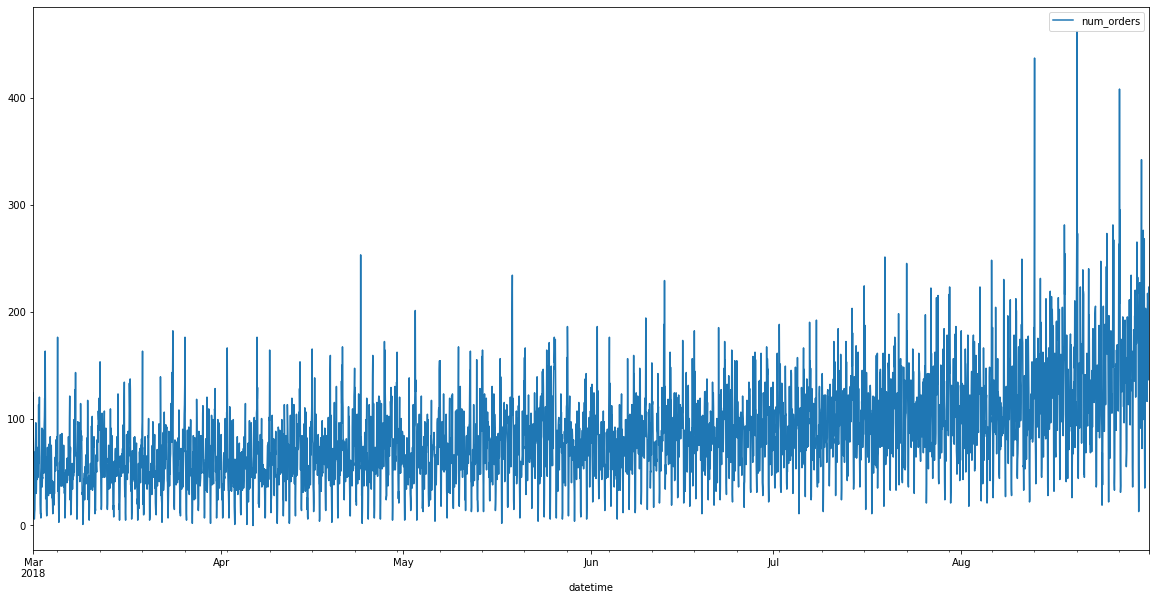

In [40]:
data_taxi = data_taxi .resample('1H').sum()
data_taxi.plot(figsize=F_size)

In [41]:
print('Доля пропусков в столбце ,%:') 
rezul=data_taxi.isna().mean() * 100
print(rezul)
print('Дубликатов = ',data_taxi.duplicated().sum()) 

Доля пропусков в столбце ,%:
num_orders    0.0
dtype: float64
Дубликатов =  4165


## Анализ

### Сезонность и тренд

<AxesSubplot:xlabel='datetime'>

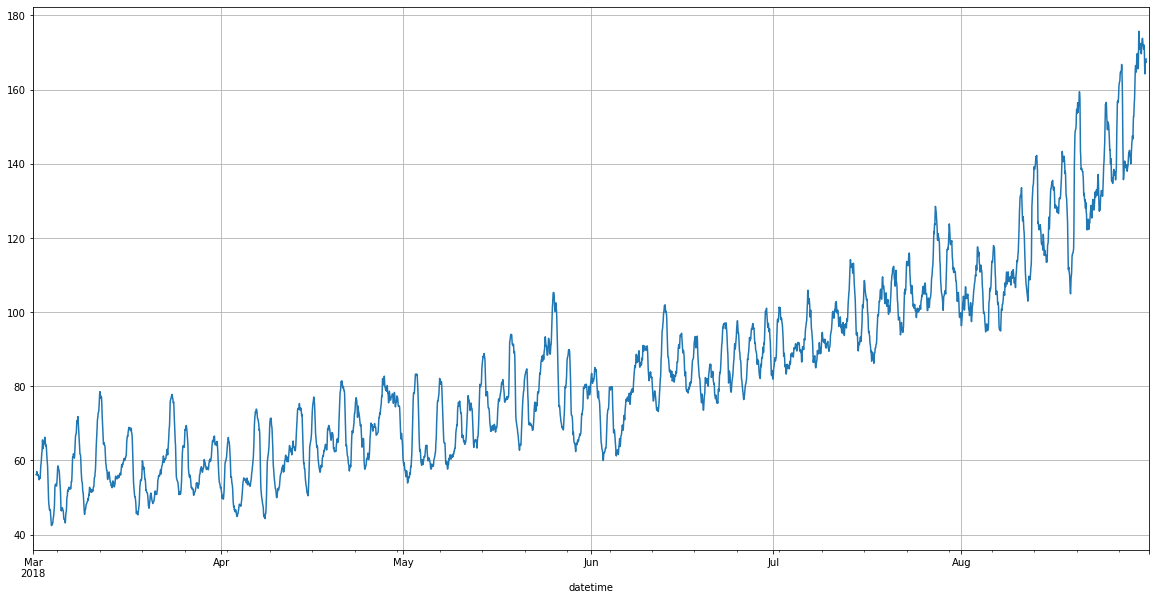

In [42]:
decomposed_data_taxi = seasonal_decompose(data_taxi) 
decomposed_data_taxi.trend.plot(grid=True,figsize=F_size)

<AxesSubplot:xlabel='datetime'>

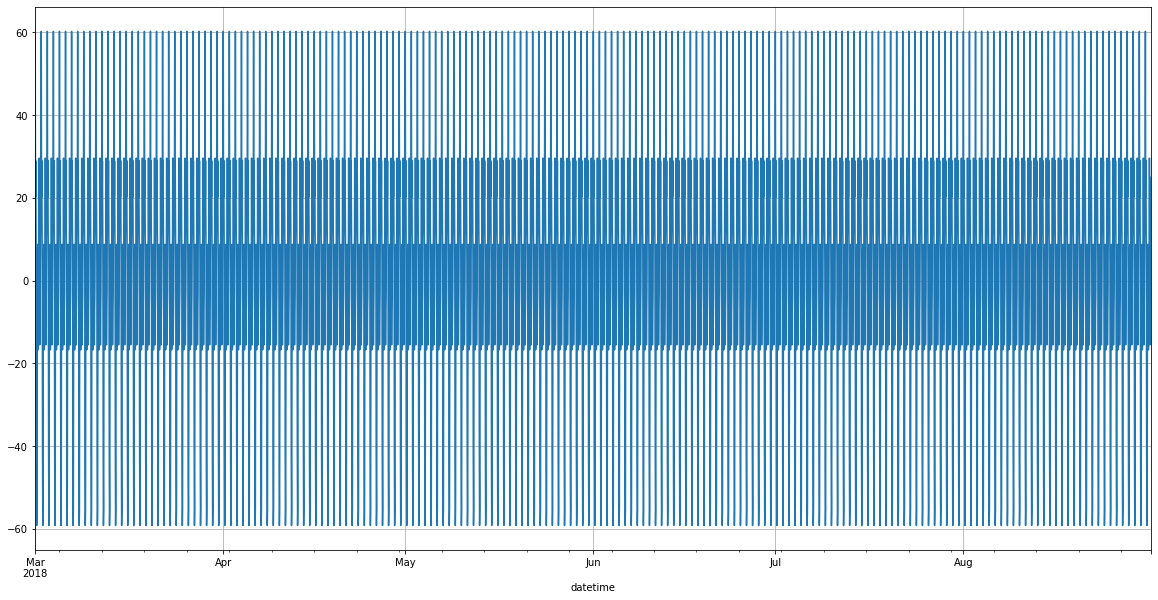

In [43]:
decomposed_data_taxi.seasonal.plot(grid=True, figsize=F_size) 

<AxesSubplot:xlabel='datetime'>

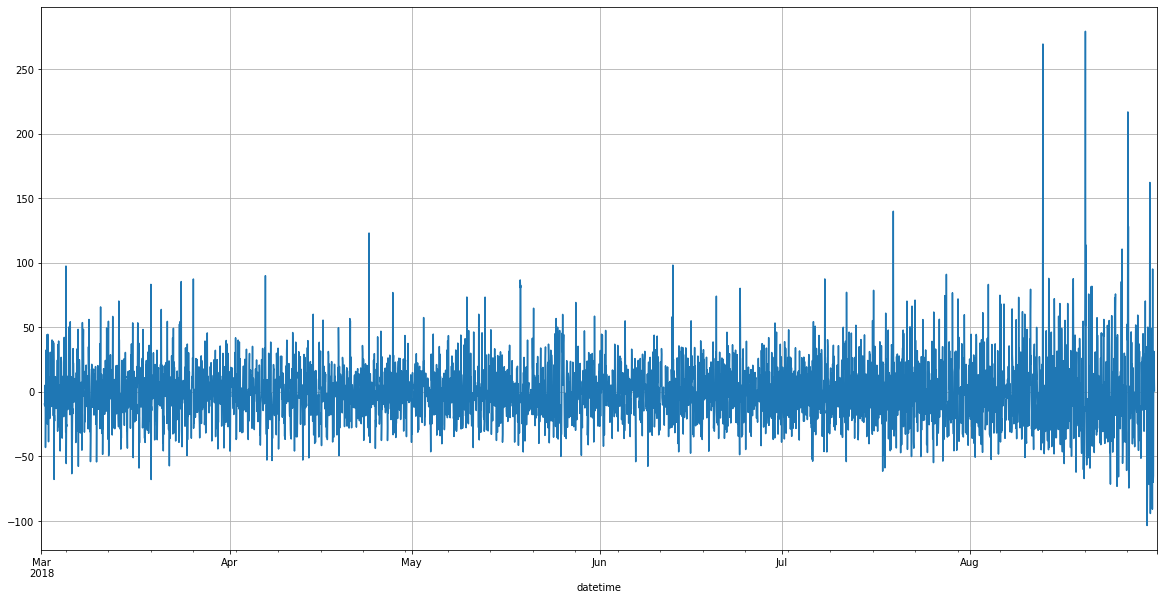

In [44]:
decomposed_data_taxi.resid.plot(grid=True,figsize=F_size) # остаток от декомпозиции 

**Виден тренд на увеличения заказов такси с июня, возможно влияние отпусков и дачного сезона.**

###  Данные за 2 месяца

<AxesSubplot:xlabel='datetime'>

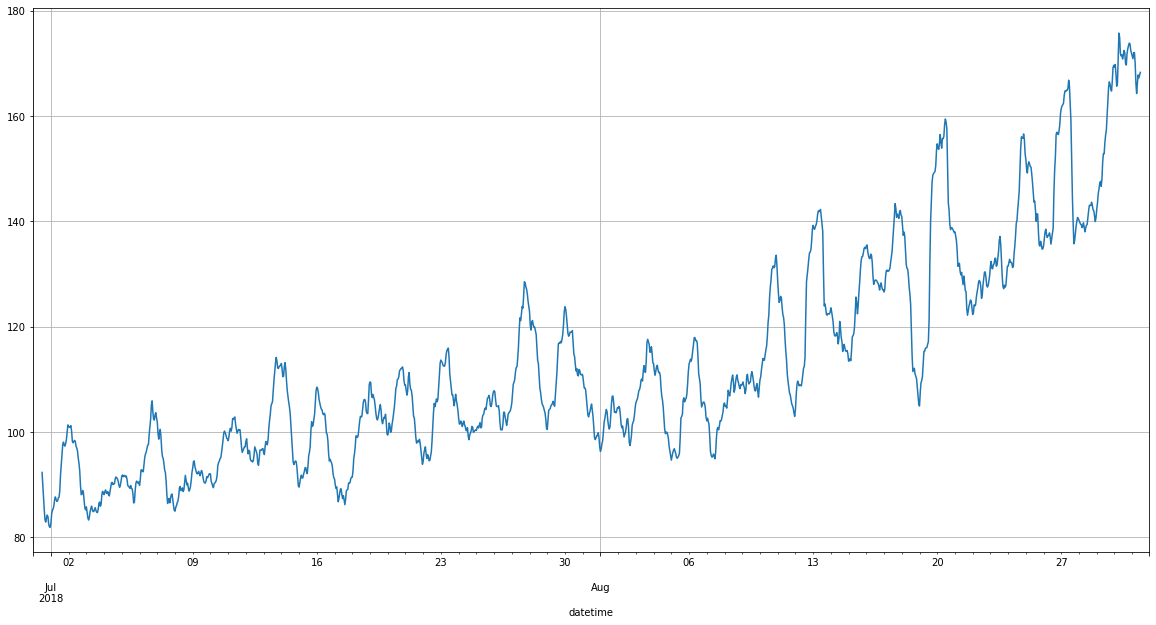

In [45]:
decomposed_data_taxi = seasonal_decompose(data_taxi['2018-06-30':'2018-08-31'])
decomposed_data_taxi.trend.plot(grid=[True], figsize=F_size)

<AxesSubplot:xlabel='datetime'>

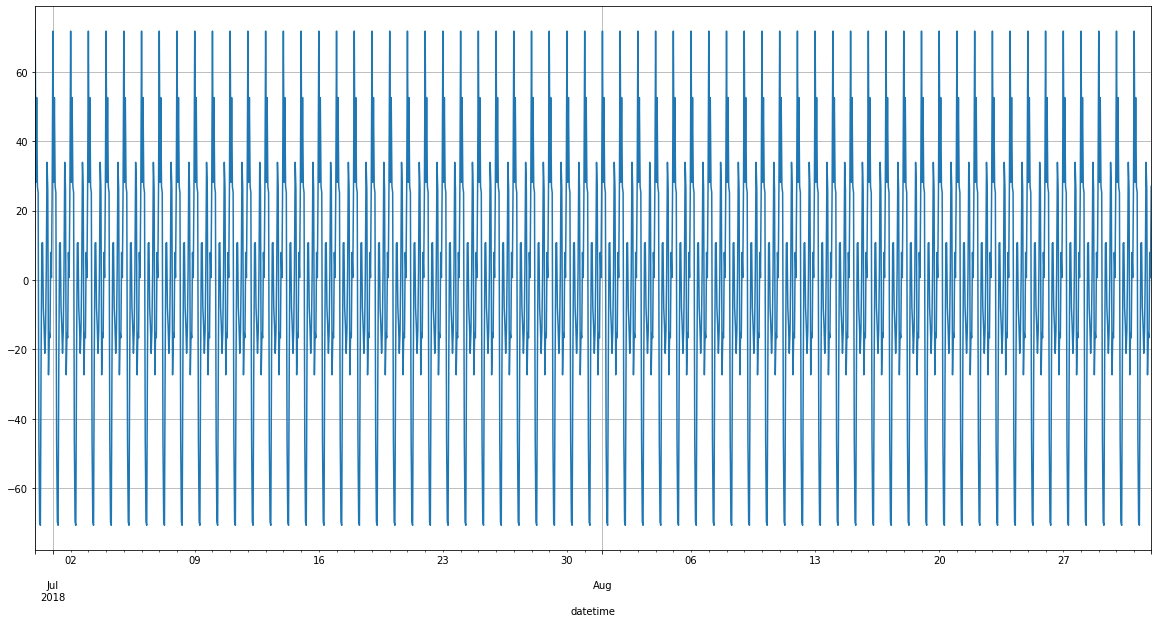

In [46]:
decomposed_data_taxi.seasonal.plot(grid=True, figsize=F_size)

<AxesSubplot:xlabel='datetime'>

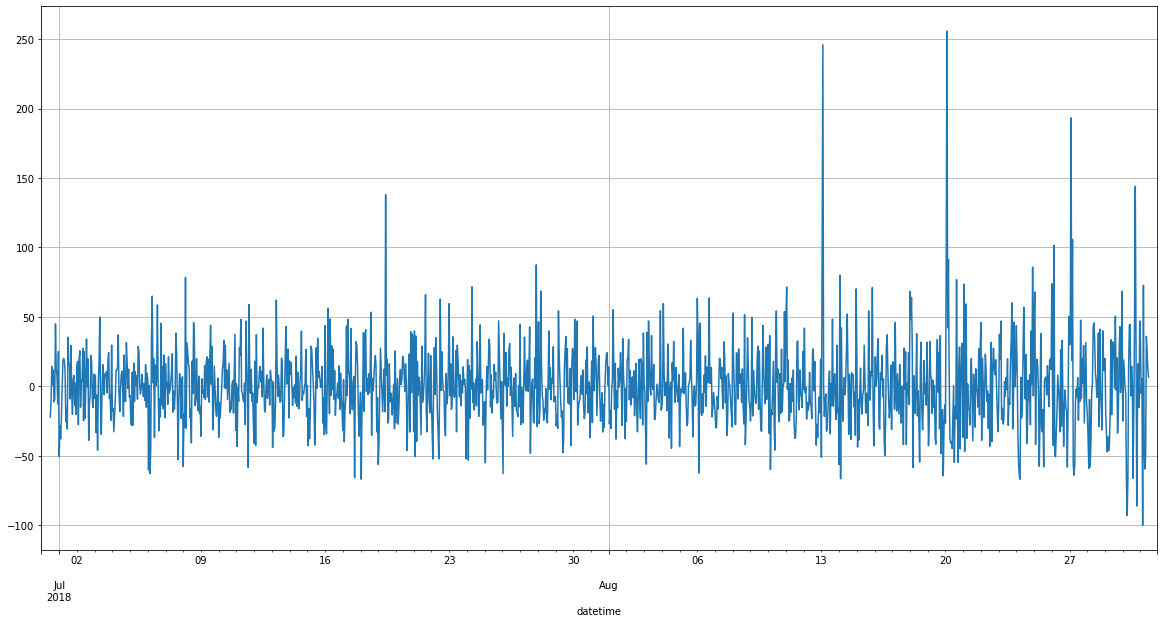

In [47]:
decomposed_data_taxi.resid.plot(grid=True, figsize=F_size)

### Посмотрим закономерности в меньшем масштабе, например за поледние 2 недели

<AxesSubplot:xlabel='datetime'>

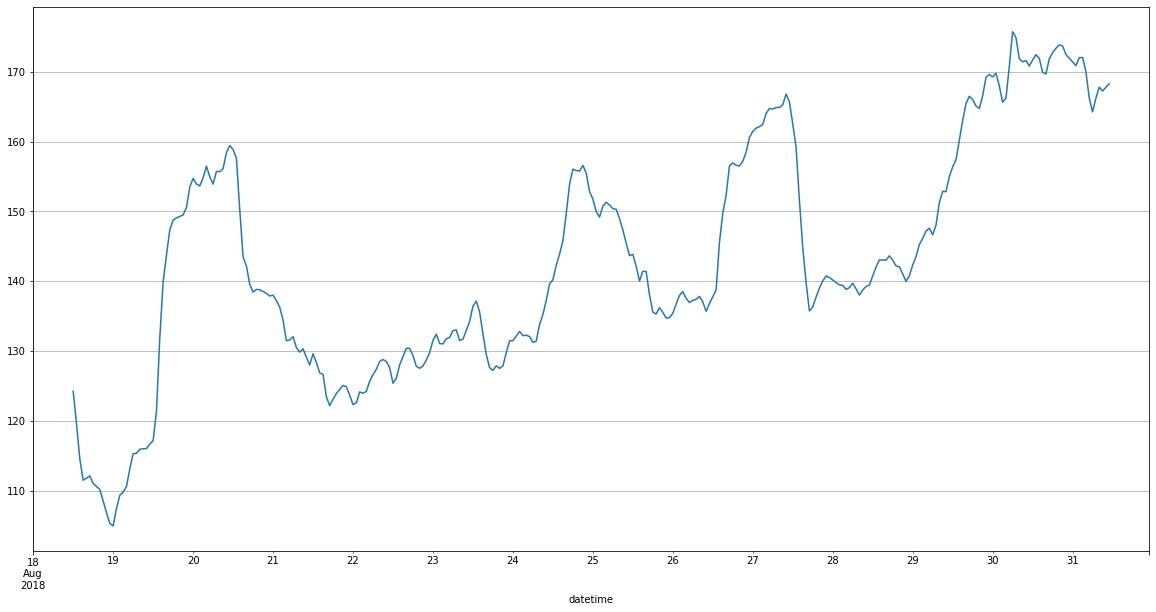

In [48]:
decomposed_data_taxi = seasonal_decompose(data_taxi['2018-08-18':'2018-08-31'])
decomposed_data_taxi.trend.plot(grid=[True], figsize=F_size)

<AxesSubplot:xlabel='datetime'>

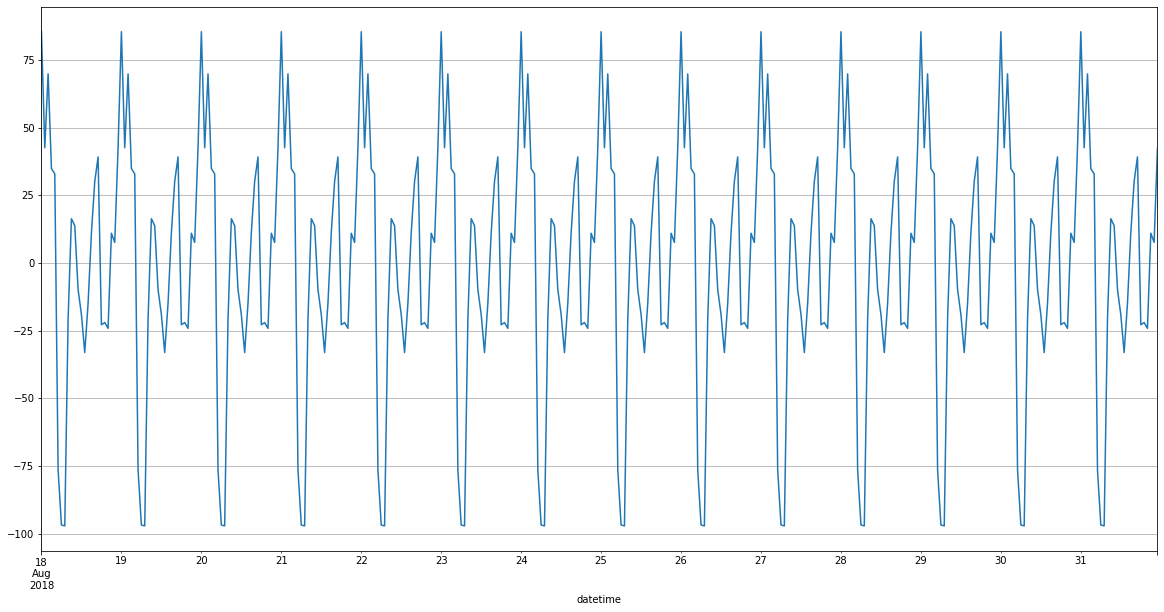

In [49]:
decomposed_data_taxi.seasonal.plot(grid=True, figsize=F_size)

<AxesSubplot:xlabel='datetime'>

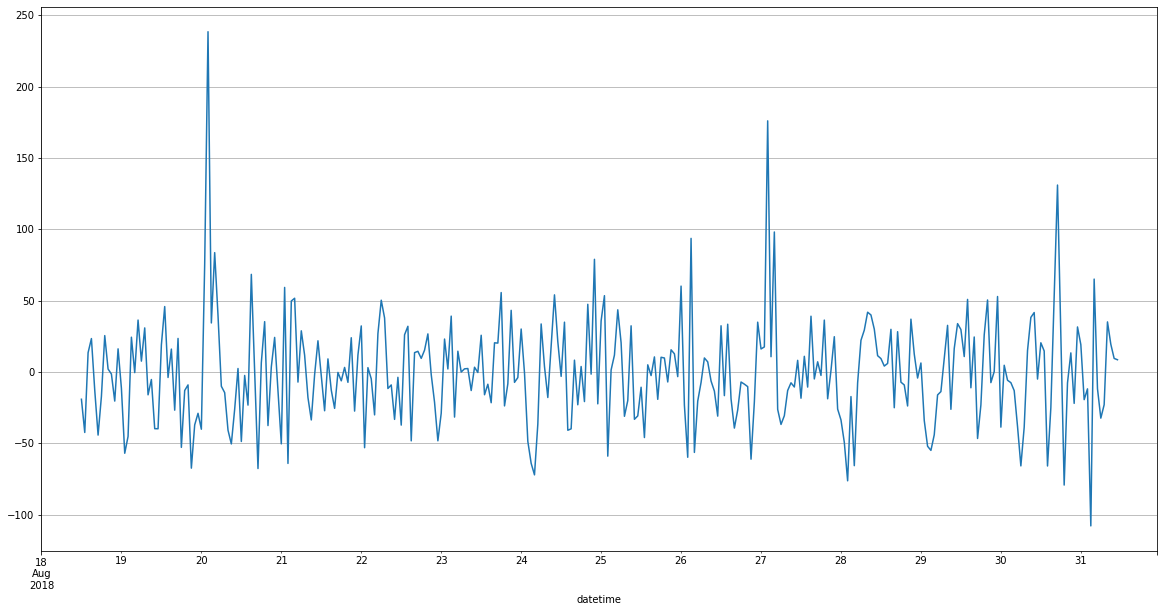

In [50]:
decomposed_data_taxi.resid.plot(grid=True, figsize=F_size)

**Наблюдается тренд к росту и наблюдается периодичность**

### Посмотрим данные за 1 неделю

<AxesSubplot:xlabel='datetime'>

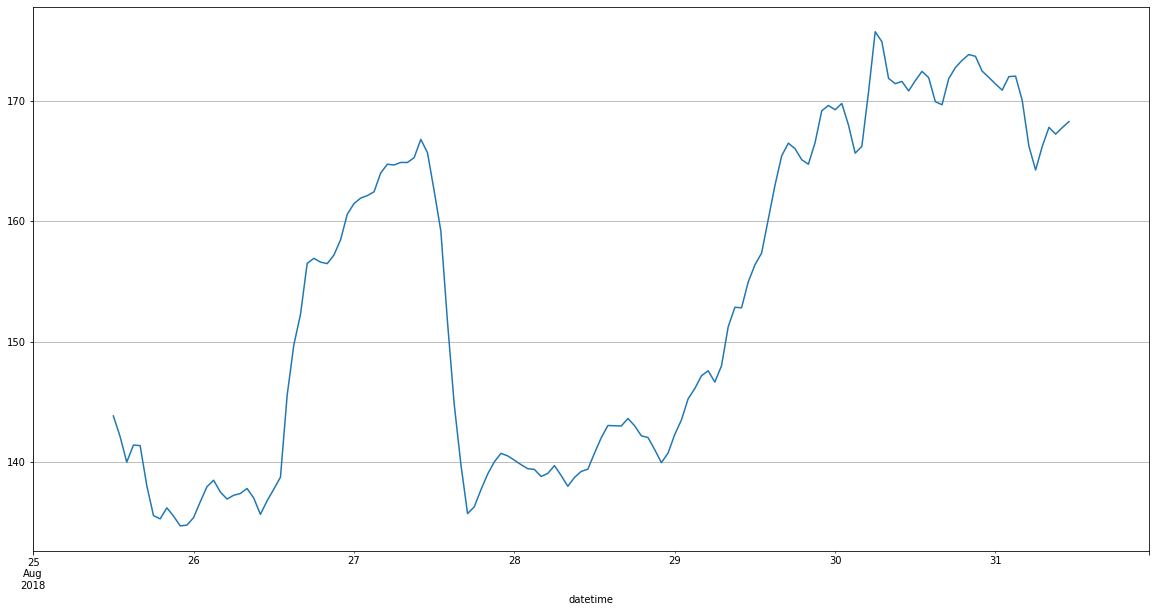

In [51]:
decomposed_data_taxi = seasonal_decompose(data_taxi['2018-08-25':'2018-08-31'])
decomposed_data_taxi.trend.plot(grid=[True], figsize=F_size)

<AxesSubplot:xlabel='datetime'>

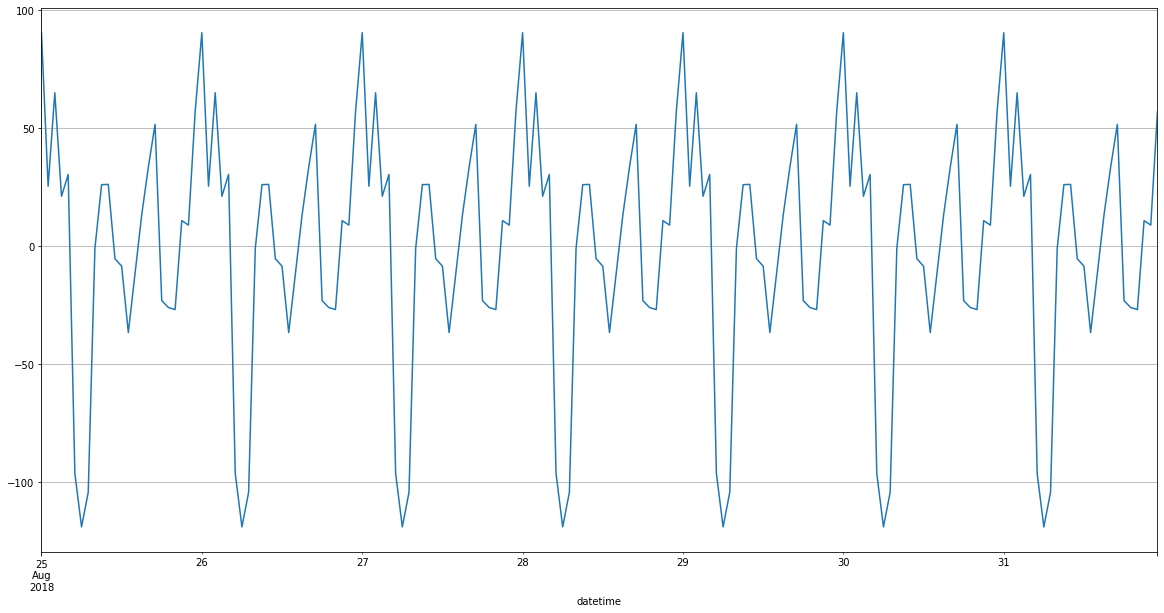

In [52]:
decomposed_data_taxi.seasonal.plot(grid=True, figsize=F_size)

<AxesSubplot:xlabel='datetime'>

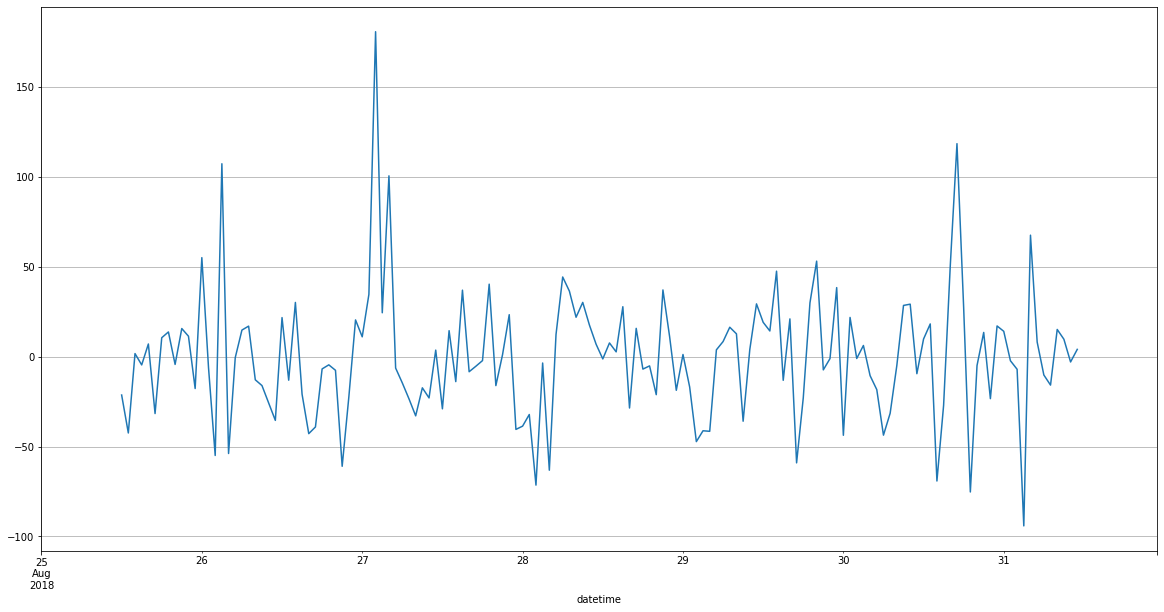

In [53]:
decomposed_data_taxi.resid.plot(grid=True, figsize=F_size)

### Посмотрим данные за 1 день

<AxesSubplot:xlabel='datetime'>

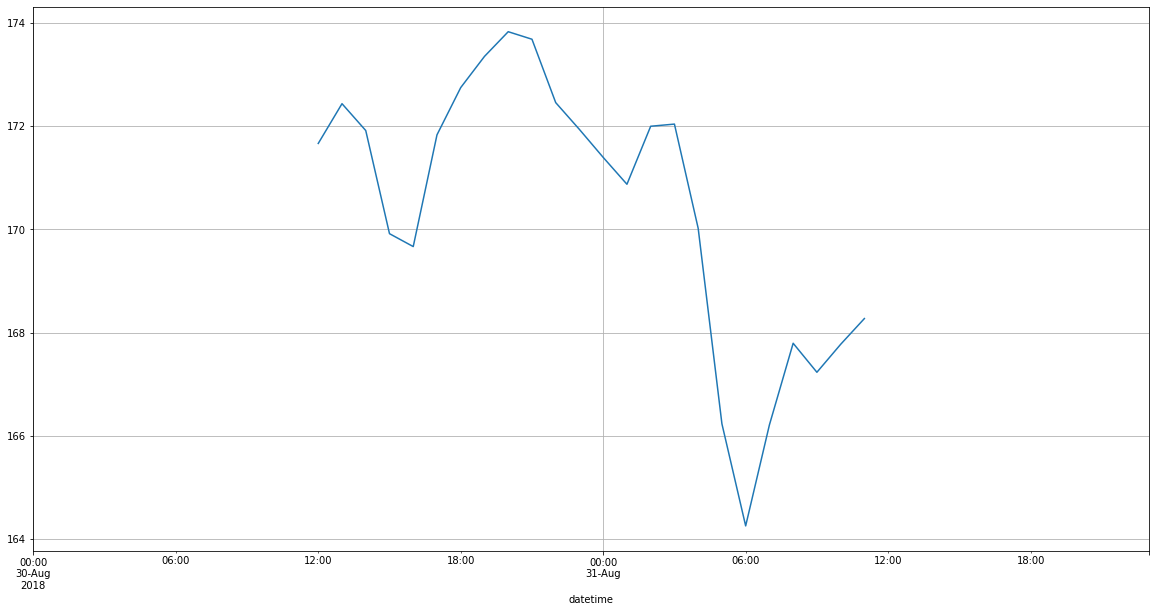

In [54]:
decomposed_data_taxi = seasonal_decompose(data_taxi['2018-08-30':'2018-08-31'])
decomposed_data_taxi.trend.plot(grid=[True], figsize=F_size)

<AxesSubplot:xlabel='datetime'>

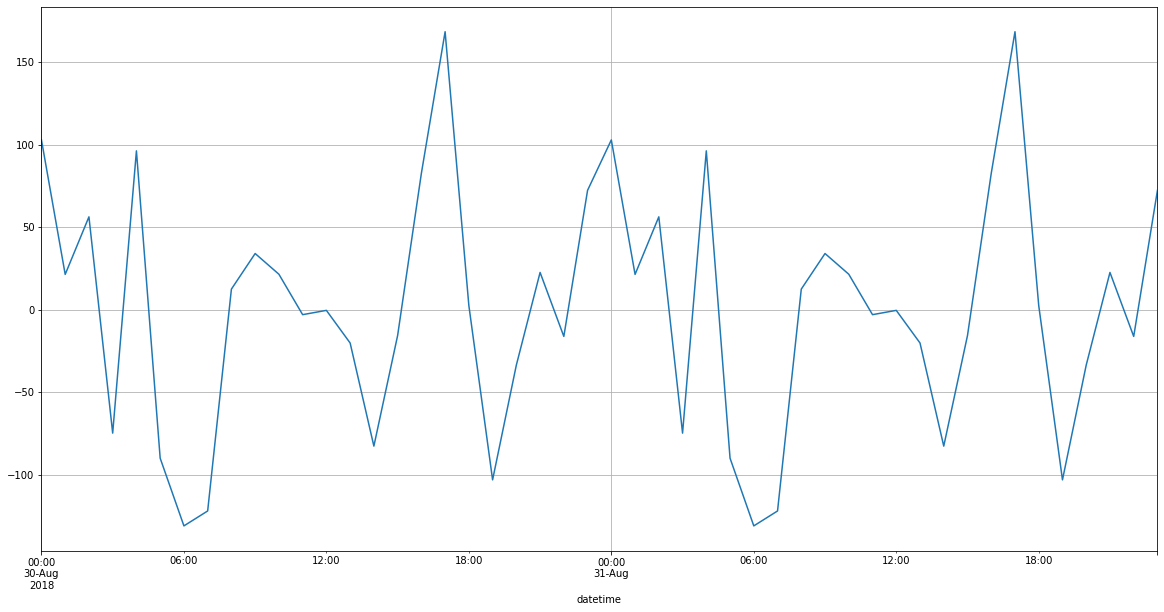

In [55]:
decomposed_data_taxi.seasonal.plot(grid=True, figsize=F_size)

<AxesSubplot:xlabel='datetime'>

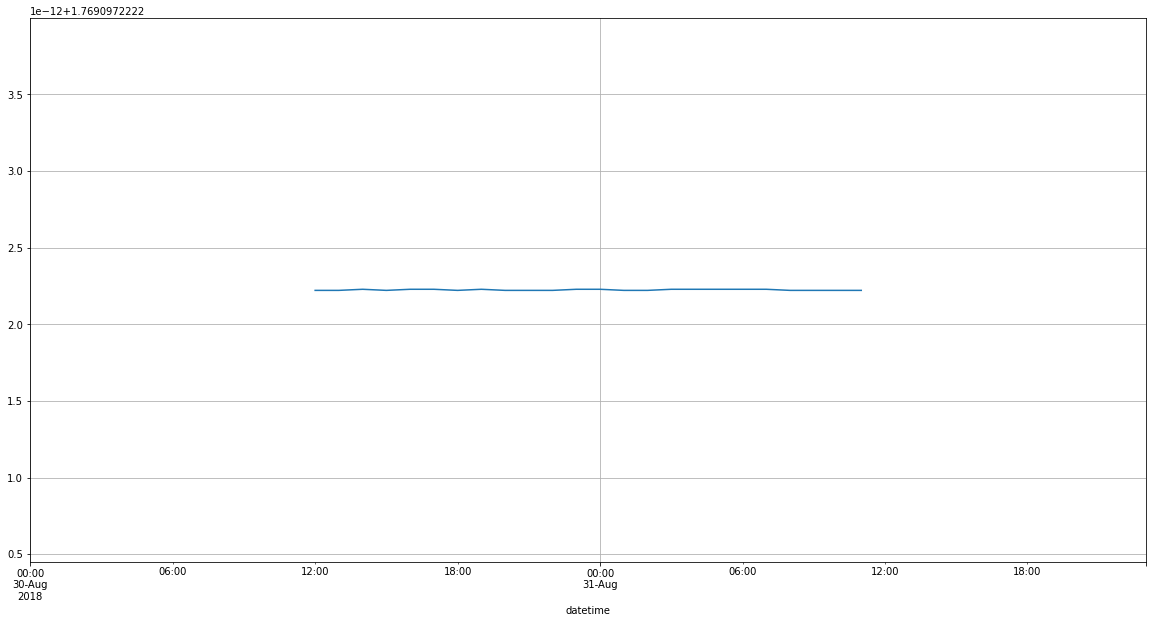

In [56]:
decomposed_data_taxi.resid.plot(grid=True, figsize=F_size)

### Вывод

1. Дисперсия со временем увеличивается, особенно заметно в последний месяц
2. По тренду видно, что со временем все больше и больше людей пользуется услугой заказа такси, что можно объяснить сезонностью. Лето отпуска, дачи, поэтому четко судить о дальнейшем увеличении заказов судить опрометчиво
3. В рамках 1-го дня так же присутствуют максимум и минимумы количества заказов такси, наибольшее количество заказов в конце рабочего дня вечером и в районе полночи когда перестает ходить общественный транспорт. Минимум заказов наблюдается в районе обеденного времени и утром в районе 6 часов.
4.  Временной ряд не является стационарным, так как подвержен тренду, который меняется во времени.
5. Периодичность примерно 12 часов (в диапазоне суток), так же 24 часа, 5 и  7 дней на длинной дистанции

## Обучение

**Создание признаков**

In [57]:
    data_taxi['hour'] = data_taxi.index.hour
    data_taxi['day'] = data_taxi.index.day
    data_taxi['dayofweek'] = data_taxi.index.dayofweek
    data_taxi['month'] =data_taxi.index.month
    for lag in range(1, 3*24 + 1):
        data_taxi['lag_{}'.format(lag)] = data_taxi['num_orders'].shift(lag)
    data_taxi['rolling_mean'] = data_taxi['num_orders'].shift().rolling(3).mean()
    
    display(data_taxi.head(10))

,num_orders,hour,day,dayofweek,month,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_64,lag_65,lag_66,lag_67,lag_68,lag_69,lag_70,lag_71,lag_72,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,0,1,3,3,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,1,3,3,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2,1,3,3,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,3,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,93.333333
2018-03-01 04:00:00,43,4,1,3,3,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,74.000000
2018-03-01 05:00:00,6,5,1,3,3,43.0,66.0,71.0,85.0,124.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.000000
2018-03-01 06:00:00,12,6,1,3,3,6.0,43.0,66.0,71.0,85.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.333333
2018-03-01 07:00:00,15,7,1,3,3,12.0,6.0,43.0,66.0,71.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.333333
2018-03-01 08:00:00,34,8,1,3,3,15.0,12.0,6.0,43.0,66.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.000000


**Разделение выборки**

In [81]:
#features_train, features_test, target_train, target_test = train_test_split(features, target,shuffle=False, test_size=0.1)
train, test = train_test_split( data_taxi,shuffle=False, test_size=0.1)

**Масштабирование признаков**

In [62]:
#scaler = StandardScaler()
#scaler.fit(features_train)
#features_train = scaler.transform(features_train)
#features_test = scaler.transform(features_test)

cv выборка для временных рядов через TimeSeriesSplit

In [86]:
def cv_time_series_rmse(regressor, data, target_column, n_splits, max_train_size): 
    tscv = TimeSeriesSplit(n_splits = n_splits, max_train_size = max_train_size)  
    RMSE = 0.0
    for train_index, test_index in tscv.split(data):
        train = data.iloc[train_index] 
        test = data.iloc[test_index] 
        train_features = train.drop(target_column, axis=1) 
        train_target = train[target_column] 
        test_features = test.drop(target_column, axis=1) 
        test_target = test[target_column] 
        regressor.fit(train_features, train_target)
        RMSE += mean_squared_error(test_target, regressor.predict(test_features)) ** 0.5
    return RMSE / n_splits

**Список моделей**

1. LinearRegression
2. DecisionTreeRegressor
3. RandomForestRegressor
4. CatBoostRegressor
5. LGBMRegressor
6. DummyRegressor

**Параметры кросс валидации**

In [87]:
cv_train_test_split = (train.shape[0] * 4 //5) # размер выборки для вросс калидации
cv_splits = 5 #число выборок и прогонов соответственно

### Линейная регрессия

**Подбор параметров и кросс валидация**

In [88]:
model_line = LinearRegression()

result_CV=cv_time_series_rmse(model_line, 
                    data=train, 
                    target_column='num_orders', 
                    n_splits=cv_splits, 
                    max_train_size=cv_train_test_split)
print(f'Cреднеквадратичная ошибка RMSE при кросс валидации= {result_CV:.4}')

Cреднеквадратичная ошибка RMSE при кросс валидации= 1.102e+11


### Модель, дерево решений

**Подбор параметров и кросс валидация**

In [77]:
%%time
model_DTR = DecisionTreeRegressor() 
parametrs=[{ 
    'max_depth':range(1,30,1), 
    'criterion':['mse'],  
    'random_state':[2504] 
}]
search_best_param=GridSearchCV(model_DTR,  
                               parametrs, 
                               scoring='neg_mean_squared_error')  
search_best_param.fit(features_train,  target_train) 
print('Cреднеквадратичная ошибка RMSE ')
means =search_best_param.cv_results_['mean_test_score']
for mean, params in zip(means, search_best_param.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
print()
print("Наилучшие найденые параметры:")
print()
print(search_best_param.best_params_)


Cреднеквадратичная ошибка RMSE при кросс валидации
34.691705 for {'criterion': 'mse', 'max_depth': 1, 'random_state': 2504}
30.375668 for {'criterion': 'mse', 'max_depth': 2, 'random_state': 2504}
28.292900 for {'criterion': 'mse', 'max_depth': 3, 'random_state': 2504}
27.135034 for {'criterion': 'mse', 'max_depth': 4, 'random_state': 2504}
26.698712 for {'criterion': 'mse', 'max_depth': 5, 'random_state': 2504}
27.166261 for {'criterion': 'mse', 'max_depth': 6, 'random_state': 2504}
27.464342 for {'criterion': 'mse', 'max_depth': 7, 'random_state': 2504}
28.509645 for {'criterion': 'mse', 'max_depth': 8, 'random_state': 2504}
29.069468 for {'criterion': 'mse', 'max_depth': 9, 'random_state': 2504}
30.448511 for {'criterion': 'mse', 'max_depth': 10, 'random_state': 2504}
30.814240 for {'criterion': 'mse', 'max_depth': 11, 'random_state': 2504}
31.313397 for {'criterion': 'mse', 'max_depth': 12, 'random_state': 2504}
32.395435 for {'criterion': 'mse', 'max_depth': 13, 'random_state': 25

**Кросс валидация**

In [84]:
model_DTR = DecisionTreeRegressor(random_state=2504, max_depth=search_best_param.best_params_['max_depth']) 

result_CV_DTR=cv_time_series_rmse(model_DTR, 
                    data=train, 
                    target_column='num_orders', 
                    n_splits=cv_splits, 
                    max_train_size=cv_train_test_split)
print(f'Cреднеквадратичная ошибка RMSE при кросс валидации= {result_CV_DTR:.4}') 

Cреднеквадратичная ошибка RMSE при кросс валидации= 29.11


### Модель случайный лес

**Подбор параметров и кросс валидация**

In [91]:
%%time
model_RFR = RandomForestRegressor ()
parametrs={
    'n_estimators':range(110,151,10),
    'max_depth':range(8,15,1) 
}
search_best_param_RFR=GridSearchCV(model_RFR,
                                   parametrs,
                                  scoring='neg_mean_squared_error')
search_best_param_RFR.fit(features_train, target_train)


print('Cреднеквадратичная ошибка RMSE')
means =search_best_param_RFR.cv_results_['mean_test_score']
for mean, params in zip(means, search_best_param_RFR.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
print()
print("Наилучшие найденые параметры:")
print()
print(search_best_param_RFR.best_params_)

Cреднеквадратичная ошибка RMSE при кросс валидации
23.660167 for {'max_depth': 8, 'n_estimators': 110}
23.714343 for {'max_depth': 8, 'n_estimators': 120}
23.629855 for {'max_depth': 8, 'n_estimators': 130}
23.617329 for {'max_depth': 8, 'n_estimators': 140}
23.691284 for {'max_depth': 8, 'n_estimators': 150}
23.500114 for {'max_depth': 9, 'n_estimators': 110}
23.552887 for {'max_depth': 9, 'n_estimators': 120}
23.502164 for {'max_depth': 9, 'n_estimators': 130}
23.478131 for {'max_depth': 9, 'n_estimators': 140}
23.529817 for {'max_depth': 9, 'n_estimators': 150}
23.473210 for {'max_depth': 10, 'n_estimators': 110}
23.354877 for {'max_depth': 10, 'n_estimators': 120}
23.454474 for {'max_depth': 10, 'n_estimators': 130}
23.414112 for {'max_depth': 10, 'n_estimators': 140}
23.344776 for {'max_depth': 10, 'n_estimators': 150}
23.388718 for {'max_depth': 11, 'n_estimators': 110}
23.371289 for {'max_depth': 11, 'n_estimators': 120}
23.471344 for {'max_depth': 11, 'n_estimators': 130}
23.36

**Кросс валидация**

In [93]:
model_RFR =RandomForestRegressor (n_estimators=search_best_param_RFR.best_params_['n_estimators'],
                                  max_depth=search_best_param_RFR.best_params_['max_depth'])


result_CV_RFR=cv_time_series_rmse(model_RFR , 
                    data=train, 
                    target_column='num_orders', 
                    n_splits=cv_splits, 
                    max_train_size=cv_train_test_split)
print(f'Cреднеквадратичная ошибка RMSE при кросс валидации= {result_CV_RFR:.4}') 

Cреднеквадратичная ошибка RMSE при кросс валидации= 24.1


### Модель,  CatBoostRegressor регрессия

**Подбор параметров и кросс валидация**

In [30]:
%%time
model_CatBR = CatBoostRegressor()
params=[{'learning_rate': [0.5], 
                              'iterations': [20], 
                              'depth': [8], 
                              'random_state':[2504], 
                              'verbose':[False], 
                                }]

search_best_param_CatBR=GridSearchCV(model_CatBR,
                                    parametrs,
                                     cv=3,
                                     scoring='neg_mean_squared_error')

CPU times: user 151 µs, sys: 0 ns, total: 151 µs
Wall time: 155 µs


In [94]:
%%time
model_CatBR = CatBoostRegressor(learning_rate= 0.05, 
                              iterations= 500,
                              depth= 5,
                             random_state= 2504, 
                              verbose=False 
                              )

CPU times: user 143 µs, sys: 1e+03 ns, total: 144 µs
Wall time: 149 µs


**Кросс валидация**

In [95]:
result_CV_CatBR=cv_time_series_rmse(model_CatBR , 
                    data=train, 
                    target_column='num_orders', 
                    n_splits=cv_splits, 
                    max_train_size=cv_train_test_split)
print(f'Cреднеквадратичная ошибка RMSE при кросс валидации= {result_CV_CatBR:.4}') 

Cреднеквадратичная ошибка RMSE при кросс валидации= 23.53


### Модель LGBMRegressor

In [97]:
%%time
model_LGBMR = LGBMRegressor() 
params = [{'num_iterations': [10, 50, 100],
            'max_depth': [3, 5, 7],
            'random_state':[2504]}]
search_best_param_LGBMR = GridSearchCV(model_LGBMR,
                                       params,
                                       scoring='neg_mean_squared_error')
search_best_param_LGBMR.fit(features_train, target_train)
print(search_best_param_LGBMR.best_params_)

{'max_depth': 7, 'num_iterations': 100, 'random_state': 2504}
CPU times: user 6min, sys: 1.91 s, total: 6min 2s
Wall time: 6min 4s


In [98]:
means = search_best_param_LGBMR.cv_results_['mean_test_score']
print(f'Cреднеквадратичная ошибка RMSE:')

for mean, params in zip(means,  search_best_param_LGBMR.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
print()
print("Наилучшие найденые параметры:")
print()
print(search_best_param_LGBMR.best_params_)

Cреднеквадратичная ошибка RMSE:
28.833029 for {'max_depth': 3, 'num_iterations': 10, 'random_state': 2504}
23.503205 for {'max_depth': 3, 'num_iterations': 50, 'random_state': 2504}
22.927015 for {'max_depth': 3, 'num_iterations': 100, 'random_state': 2504}
27.834010 for {'max_depth': 5, 'num_iterations': 10, 'random_state': 2504}
23.160602 for {'max_depth': 5, 'num_iterations': 50, 'random_state': 2504}
22.866687 for {'max_depth': 5, 'num_iterations': 100, 'random_state': 2504}
27.455614 for {'max_depth': 7, 'num_iterations': 10, 'random_state': 2504}
22.761392 for {'max_depth': 7, 'num_iterations': 50, 'random_state': 2504}
22.646736 for {'max_depth': 7, 'num_iterations': 100, 'random_state': 2504}

Наилучшие найденые параметры:

{'max_depth': 7, 'num_iterations': 100, 'random_state': 2504}


**Кросс валидация**

In [99]:
model_LGBMR = LGBMRegressor(num_iterations=search_best_param_LGBMR.best_params_['num_iterations'],
            max_depth= search_best_param_LGBMR.best_params_['max_depth'],
            random_state=search_best_param_LGBMR.best_params_['random_state'])

In [101]:
result_CV_LGBMR=cv_time_series_rmse(model_LGBMR, 
                    data=train, 
                    target_column='num_orders', 
                    n_splits=cv_splits, 
                    max_train_size=cv_train_test_split)
print(f'Cреднеквадратичная ошибка RMSE при кросс валидации= {result_CV_LGBMR:.4}') 

Cреднеквадратичная ошибка RMSE при кросс валидации= 23.79


## Тестирование

In [102]:
models_scors = pd.DataFrame(columns = ['model', 'RSME', 'lirning_time', 'predicting_time'])

### Линейная регрессия

**Тест наилучшей модели**

In [103]:
%%time

start_time = time.time() 
model_line.fit(features_train, target_train)  
lirning_time = time.time() - start_time 
start_time = time.time()
predictions_line = model_line.predict(features_test) 
predicting_time = time.time()- start_time

result_line_1 =math.sqrt(mean_squared_error(target_test, predictions_line,squared=True)) 
print(f'Cреднеквадратичная ошибка RMSE = {result_line_1:.4}') 

Cреднеквадратичная ошибка RMSE = 42.68
CPU times: user 70.5 ms, sys: 72.5 ms, total: 143 ms
Wall time: 95 ms


**Сохранение результатов**

In [104]:
models_scors = models_scors.append({'model': model_line, 'RSME': result_line_1,
                    'lirning_time': lirning_time, 'predicting_time': predicting_time}, ignore_index=True)

### Модель, дерево решений

**Тест наилучшей модели**

In [105]:
%%time
model_DTR = DecisionTreeRegressor(random_state=2504, max_depth=search_best_param.best_params_['max_depth']) 
start_time = time.time() 
model_DTR.fit(features_train, target_train)
lirning_time = time.time() - start_time 
start_time = time.time()
predictions_DTR = model_DTR.predict(features_test) 
predicting_time = time.time()- start_time

result_DTR =math.sqrt(mean_squared_error(target_test, predictions_DTR,squared=True)) 
print(f'Cреднеквадратичная ошибка RMSE = {result_DTR:.4}') 

Cреднеквадратичная ошибка RMSE = 61.1
CPU times: user 82.2 ms, sys: 4 ms, total: 86.2 ms
Wall time: 86.5 ms


**Сохранение результатов**

In [106]:
models_scors = models_scors.append({'model': 'DecisionTreeRegressor', 'RSME': result_DTR,
                    'lirning_time': lirning_time, 'predicting_time': predicting_time}, ignore_index=True)

### Модель случайный лес

**Тест наилучшей модели**

In [108]:
%%time
model_RFR =RandomForestRegressor (n_estimators=search_best_param_RFR.best_params_['n_estimators'],
                                  max_depth=search_best_param_RFR.best_params_['max_depth']
                                 )

start_time = time.time() 
model_RFR.fit(features_train, target_train)
lirning_time = time.time() - start_time 
start_time = time.time()
predictions_RFR = model_RFR.predict(features_test) 
predicting_time = time.time()- start_time

result_RFR =math.sqrt(mean_squared_error(target_test, predictions_RFR,squared=True)) 
print(f'Cреднеквадратичная ошибка RMSE = {result_RFR:.4}') 

Cреднеквадратичная ошибка RMSE = 41.1
CPU times: user 17.3 s, sys: 0 ns, total: 17.3 s
Wall time: 17.3 s


**Сохранение результатов**

In [109]:
models_scors = models_scors.append({'model': 'RandomForestRegressor', 'RSME': result_RFR,
                    'lirning_time': lirning_time, 'predicting_time': predicting_time}, ignore_index=True)

### Модель,  CatBoostRegressor регрессия

**Тест наилучшей модели**

In [110]:
%%time 
model_CatBR = CatBoostRegressor(learning_rate=0.05, 
                              iterations=500, 
                              depth=5, 
                              random_state=2504, 
                              verbose=False)

start_time = time.time()
model_CatBR.fit(features_train,target_train) 
lirning_time = time.time() - start_time
start_time = time.time()
predictions_CatBR = model_CatBR.predict(features_test) 
predicting_time = time.time()- start_time

result_CatBR =math.sqrt(mean_squared_error(target_test, predictions_CatBR,squared=True)) 
print(f'Cреднеквадратичная ошибка RMSE = {result_CatBR:.4}') 

Cреднеквадратичная ошибка RMSE = 38.65
CPU times: user 5 s, sys: 60.4 ms, total: 5.06 s
Wall time: 5.71 s


**Сохранение результатов**

In [111]:
models_scors = models_scors.append({'model': 'CatBoostRegressor', 'RSME': result_CatBR,
                    'lirning_time': lirning_time, 'predicting_time': predicting_time}, ignore_index=True)

### Модель LGBMRegressor

**Тест наилучшей модели**

In [112]:
%%time

model_LGBMR = LGBMRegressor(num_iterations=search_best_param_LGBMR.best_params_['num_iterations'],
            max_depth= search_best_param_LGBMR.best_params_['max_depth'],
            random_state=search_best_param_LGBMR.best_params_['random_state'])

start_time = time.time()
model_LGBMR.fit(features_train, target_train)
lirning_time = time.time() - start_time
start_time = time.time()
predictions_LGBMR = model_LGBMR.predict(features_test) # результаты предсказания модели
predicting_time = time.time()- start_time

result_LGBMR =math.sqrt(mean_squared_error(target_test, predictions_LGBMR,squared=True)) 
print(f'Cреднеквадратичная ошибка RMSE = {result_LGBMR:.4}') # среднеквадратичная ошибка

Cреднеквадратичная ошибка RMSE = 39.43
CPU times: user 15.1 s, sys: 87.8 ms, total: 15.2 s
Wall time: 15.2 s


**Сохранение результатов**

In [113]:
models_scors = models_scors.append({'model': 'LGBMRegressor', 'RSME': result_LGBMR,
                    'lirning_time': lirning_time, 'predicting_time': predicting_time}, ignore_index=True)

### Модель DummyRegressor

**Тест константной моделью**

In [114]:
dummy_model = DummyRegressor(strategy='median')

start_time = time.time()
dummy_model.fit(features_train, target_train)
lirning_time = time.time() - start_time
start_time = time.time()
prediction = dummy_model.predict(features_test)
predict_time = time.time() - start_time

result_dummy =math.sqrt( mean_squared_error(target_test, prediction))
print(f'Cреднеквадратичная ошибка RMSE = {result_dummy }')


Cреднеквадратичная ошибка RMSE = 87.55547338425069


**Сохранение результатов**

In [115]:
models_scors = models_scors.append({'model': 'DummyRegressor', 'RSME': result_dummy,
                    'lirning_time': lirning_time, 'predicting_time': predicting_time}, ignore_index=True)

In [116]:
display(models_scors)

,model,RSME,lirning_time,predicting_time
0,LinearRegression(),42.676930,0.090439,0.003324
1,DecisionTreeRegressor,61.099472,0.083841,0.002064
2,RandomForestRegressor,41.099874,17.296266,0.021301
3,CatBoostRegressor,38.652444,5.709160,0.004093
4,LGBMRegressor,39.433413,15.229583,0.003378
5,DummyRegressor,87.555473,0.000692,0.003378


### Вывод

По полученным результатам обучения и предсказания моделей из таблицы видно, что лучшее значение RSME имеет  CatBoostRegressor, а так же данная модель имеет меньшее время обучения и предсказания по сравнению с моделью LGBMRegressor, показавшей несколько худший результат.